# Find the Similar Sheep

First, import required libraries

In [53]:
import os 
import random
import numpy as np
import glob
from PIL import Image
import pickle

import torch
from torchvision import transforms

from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
from pymilvus import connections

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [52]:
!pip install matplotlib

  Using cached contourpy-1.2.1-cp39-cp39-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.9 kB ? eta -:--:--
     ------- ------------------------------- 30.7/165.9 kB 1.4 MB/s eta 0:00:01
     --------------- --------------------- 71.7/165.9 kB 991.0 kB/s eta 0:00:01
     ----------------------------------- -- 153.6/165.9 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 165.9/165.9 kB 1.1 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
    --------------------------------------- 0.1/8.0 MB 3.3 MB/s eta 0:00:03
    --------------------------------------- 0.1/8.0 MB 2.4 MB/s eta 0:00:04
    -----------------------------

In [3]:
import torch
import glob
from torchvision import transforms

#!pip3 install --upgrade pymilvus

from getpass import getpass






### **Inception** Image search using PyTorch and Milvus

In this example, we will perform image similarity search using PyTorch and Milvus. 

We are going to use the Animals-10 dataset available in Kaggle. Download and extract the compressed archive containing the images. 

We shall make use of pre-trained Inception model to generate the vector embeddings from the images and use them for our similarity search

In [2]:
os.getcwd()

'd:\\Study\\Vector Databases\\Milvus'

- Data: https://www.kaggle.com/datasets/alessiocorrado99/animals10
- Model:
    - https://pytorch.org/hub/pytorch_vision_inception_v3/
    - https://cloud.google.com/tpu/docs/inception-v3-advanced 

In [12]:
# Get the filepaths of the images
paths = glob.glob(os.path.join('data','animals','*', '*.j*'), recursive=True)
random.shuffle(paths)

In [17]:
print("Default model path", torch.hub.get_dir())

# model_path = os.path.join('models')
# torch.hub.set_dir(model_path)

# print("New model path", torch.hub.get_dir())

Default model path C:\Users\Elif/.cache\torch\hub


In [18]:
# Load the embedding model from the tensorflow hub with the last layer removed
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

Using cache found in C:\Users\Elif/.cache\torch\hub\pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Elif/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:18<00:00, 5.80MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [21]:
# Preprocessing for images
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
# Function to create embeddings from the model
def embed(data):
    with torch.no_grad():
        input_batch = data.unsqueeze(0)
        emb = np.array(model(input_batch))
        return emb.flatten().tolist()

In [31]:
# Test the embedding generation 
test = os.path.join('data', 'animals', 'cane', 'OIP--2z_zAuTMzgYM_KynUl9CQHaE7.jpeg')
im = Image.open(test)
im = preprocess(im)
print(im.shape)
emb = embed(im)
print(len(emb))

torch.Size([3, 299, 299])
1000


In [32]:
# Configs
COLLECTION_NAME = 'SIM_SEARCH_TORCH'  # Collection name
DIMENSION = 1000  # Embedding vector size in this example
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"

# Inference Arguments
BATCH_SIZE = 128
TOP_K = 3
img_limit = 2000

In [35]:
connections.connect(
  alias="default",
  host='localhost',
  port='19530',
  # user='root',
  # password=getpass('Milvus Password: ')
)

In [36]:
# Milvus
# Drop the old collection to start fresh

if utility.has_collection(COLLECTION_NAME):
    utility.drop_collection(COLLECTION_NAME)


In [37]:
filepath_field = FieldSchema(name='filepath', dtype=DataType.VARCHAR,is_primary=True, max_length=4000)
embedding_field = FieldSchema(name='inception_embedding', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)

fields = [filepath_field, embedding_field]

# Create collection schema

schema = CollectionSchema(fields=fields)

# Create collection
collection = Collection(
    name=COLLECTION_NAME,
    schema=schema,
    using='default')
utility.list_collections()

['partition_key_collection',
 'Spam_Test',
 'Spam_Test_Copy',
 'SIM_SEARCH_TORCH',
 'Album1',
 'dynamic_schema_example']

In [38]:

data_batch = [[],[]]

for ind, path in enumerate(paths):
    im = Image.open(path).convert('RGB')
    im = preprocess(im)
    embedding = embed(im)
    data_batch[0].append(path)
    data_batch[1].append(embedding)
    # print([[path], [embedding]])

    if ind%100==0 and ind>0:
        print(f'Completed {ind} of {len(paths)} images')

    if ind==img_limit:
        break

        
print(f'Completed all the images')

Completed 100 of 26128 images
Completed 200 of 26128 images
Completed 300 of 26128 images
Completed 400 of 26128 images
Completed 500 of 26128 images
Completed 600 of 26128 images
Completed 700 of 26128 images
Completed 800 of 26128 images
Completed 900 of 26128 images
Completed 1000 of 26128 images
Completed 1100 of 26128 images
Completed 1200 of 26128 images
Completed 1300 of 26128 images
Completed 1400 of 26128 images
Completed 1500 of 26128 images
Completed 1600 of 26128 images
Completed 1700 of 26128 images
Completed 1800 of 26128 images
Completed 1900 of 26128 images
Completed 2000 of 26128 images
Completed all the images


In [42]:
# Pickle the data
embeddings_path = os.path.join('data', 'embeddings', 'img_embeddings.pkl')
pickle_file = open(embeddings_path, 'wb')
pickle.dump(data_batch, pickle_file)
pickle_file.close()

In [43]:
# insert the data in batches
with open(embeddings_path, 'rb') as handle:
    data_batch = pickle.load(handle)

tmp_batch = [[], []]
insert_bath_size = 1000
for x in range(len(data_batch[0])):
    tmp_batch[0].append(data_batch[0][x])
    tmp_batch[1].append(data_batch[1][x])

    if x>0 and x%insert_bath_size==0:
        collection.insert(tmp_batch)
        tmp_batch = [[], []]
        print(f'Inserted the batch {int(x/insert_bath_size)} to Milvus collection with insert batch size of {insert_bath_size}')
        
if tmp_batch[0]:
    collection.insert(tmp_batch)

# collection.flush()
# collection.compact()
print(f'Flushed the data to Milvus')

Inserted the batch 1 to Milvus collection with insert batch size of 1000
Inserted the batch 2 to Milvus collection with insert batch size of 1000
Flushed the data to Milvus


In [44]:
print(type(data_batch[1][x][0]))

<class 'float'>


In [45]:
# Create an index for collection. Drop any old remnant index with the same name.

collection.drop_index(index_name="IVF_FLAT_INDX_IMG_SEARCH")

index_params = {
  "metric_type":"L2",
  "index_type":"IVF_FLAT",
  "params":{"nlist":1024},
  "index_name": "IVF_FLAT_INDX_IMG_SEARCH"
}

collection.create_index(field_name="inception_embedding", index_params=index_params)

Status(code=0, message=)

In [48]:
# Test using an image 
test = os.path.join('data', 'sheep_test_images', 'sheep1.jpg')
im = Image.open(test)
im = preprocess(im)
search_embedding = embed(im)

In [49]:
# Load the collection to search
# collection.flush()
# collection.compact()
# collection.release()
collection.load(replica_number=1)

In [50]:
# Search for similar images in our collection
search_res = collection.search(data=[search_embedding], anns_field='inception_embedding', param={'nprobe': 128, 'metric_type': 'L2',}, limit=5, output_fields=['filepath'])


<Figure size 640x480 with 0 Axes>

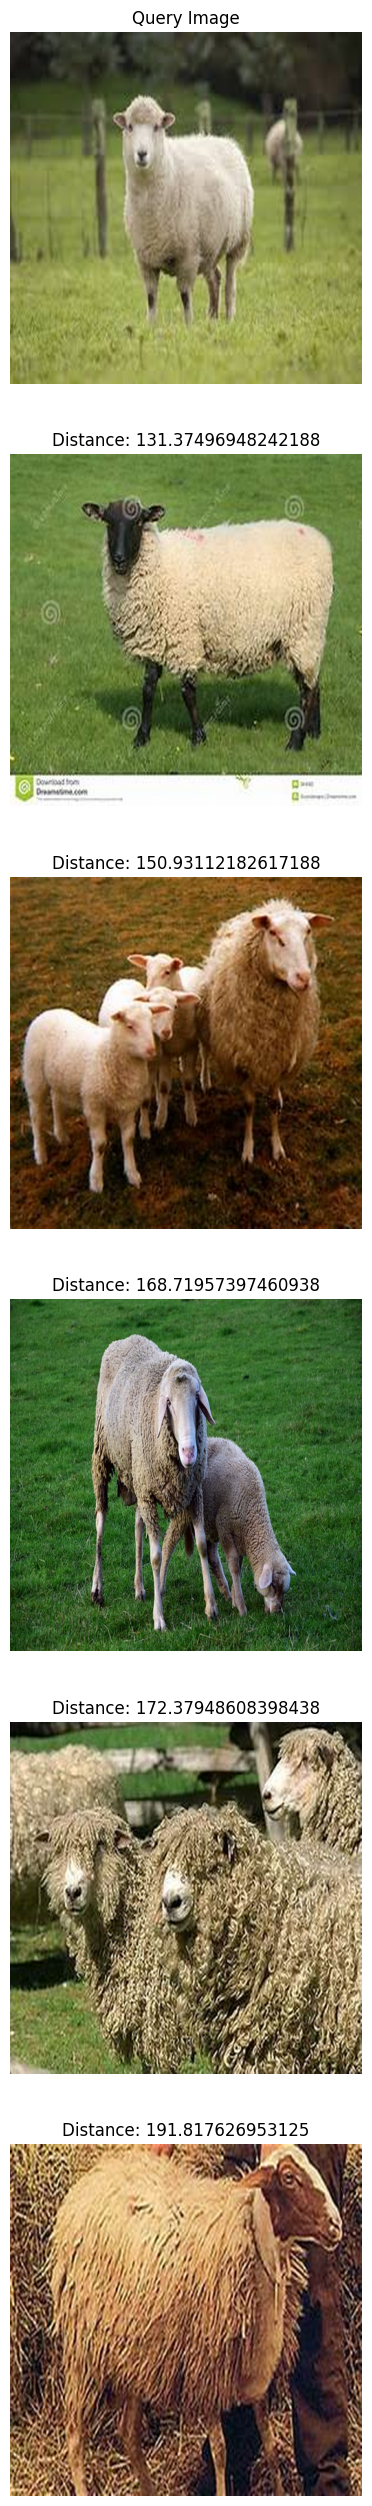

In [54]:
plt.figure()
f, axarr = plt.subplots(6, 1, figsize=(32, 32))
axarr[0].imshow(Image.open(test).resize((512, 512),  Image.Resampling.LANCZOS))
axarr[0].set_axis_off()
axarr[0].set_title('Query Image')

for indx, result in enumerate(search_res[0]):
    axarr[indx+1].set_title('Distance: ' + str(result.distance))
    axarr[indx+1].imshow(Image.open(result.entity.get('filepath')).resize((512, 512),  Image.Resampling.LANCZOS))
    axarr[indx+1].set_axis_off()

plt.show()

In [55]:
for ind, path in enumerate(paths):
    print(path)

data\animals\cane\OIP-FccIhcRt3uEoMxYysBgHigHaFj.jpeg
data\animals\cavallo\OIP-wmGB4TGQKnAieopoFxXllwHaF1.jpeg
data\animals\pecora\OIP--CqWh6W1NLb76TYL4OCGAAHaFi.jpeg
data\animals\cavallo\OIP-0puAjNkgIiWd9uX3z5DdqAHaGA.jpeg
data\animals\cane\OIP-Rq96rGrSVueYmcgN5-oCjQHaEU.jpeg
data\animals\cane\OIP-ufdsnlWArQ3LGObamaLk7wHaGX.jpeg
data\animals\ragno\OIP-oo1ULVZhz3N-RZ0jJXeYLQHaE7.jpeg
data\animals\ragno\OIP-qmdU9xjMgvNCRvX8X1lcUgHaFc.jpeg
data\animals\gallina\OIP-7ZgZDVp9HBR6jtH-jl0NhwHaFB.jpeg
data\animals\cane\OIP-P95AkgV_oOflmBYoUH-EiAHaE8.jpeg
data\animals\mucca\OIP-WmTn_eB6cGxsdpc1n7VS6AHaEC.jpeg
data\animals\gallina\OIP-ZlRcYb8x4XloTSTbCM3WlAHaFj.jpeg
data\animals\gallina\OIP-rFlBGXr64xj3HY1ryRd1-AHaFF.jpeg
data\animals\pecora\eb36b10e2df1043ed1584d05fb1d4e9fe777ead218ac104497f5c978a6ebb3bf_640.jpg
data\animals\cane\OIP-VRigvTknyMrXH3b7VoWEDQHaFj.jpeg
data\animals\gallina\OIP-arNyJSWhIdue-94fw_fW2QHaGy.jpeg
data\animals\ragno\OIP-LEttBZDWIEu4lU8AhPYTGgHaFa.jpeg
data\animals\ragno\

In [56]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri